# https://scikit-learn.org/stable/modules/clustering.html#k-means

# Obtaining 5 clusters of events using Tmax, Tmin and Rainfall over MZI for 20 years. Input data are  standardized and converted to pandas DataFrame and clustered using KMeans Algorithm. Some analysis of the same has been done.

# Import necessary Modules

In [1]:
##############Import all necessary Modules##########################
import numpy as np
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
%matplotlib inline

# Read all necessary data and subset them accordingly

In [2]:
##################Path of all files to be read########################
filename1 = '/mnt/d/DATA/IMD_MaxTemp/Maxtemp_MaxT_20*.GRD'   ##File path
filename2 = '/mnt/d/DATA/IMD_MinTemp/Mintemp_MinT_20*.GRD'   ##File path
filename3 = '/mnt/d/DATA/IMD_rainfall_1.0/RFone_imd_rf_1x1_*.nc'  #2000-2019
file_rf_sample = '/mnt/d/DATA/IMD_rainfall_1.0/RFone_imd_rf_1x1_2019.nc'

In [3]:
#######################Lat Lon Details from control File#####################
nlat=31
nlon=31
nyear=21
lons=np.arange(67.5,98.5,1)	# Define latitude and longitude as obtained from ctl file
#print(lons)
lats=np.arange(7.5,38.5,1)
#print(lats)
years=np.arange(2000,2021,1)

In [4]:
######################Fixed for the looping#######################################

npos=59
ndjf_days=120
ndjf_years=20
jjas_years=21
lp=0
nlp=0
lpdays=366
nlpdays=365
fill=99.9
a=0

na=np.full([nlat,nlon],fill,order='C')	# Array to be given for leap year day in non-leap years

In [5]:
#######################Looping for creating time series mintemp data#######################

MinTemp=np.full([nyear,lpdays,nlat,nlon],fill,order='C')# Create an empty 4d array to store data
a=0
for files in glob.glob(filename2):
	f=open(files,'rb')
	mindata=np.fromfile(f,dtype="float32",count=-1)	#  Reading the file into a 1D array
	y=years[a]
	if (y%4==0):
		mintemp=np.reshape(mindata,(lpdays,nlat,nlon),order='C')#Reading variable in required shape
		MinTemp[a,:,:,:]=mintemp	# Storing variable in the empty array
	else:
		mintemp=np.reshape(mindata,(nlpdays,nlat,nlon),order='C')
		mintemp=np.insert(mintemp,npos,na,axis=0)
		MinTemp[a,:,:,:]=mintemp	# Storing variable in the empty array
	a=a+1
	del mintemp
#print(MinTemp.shape)
del files
del f
tmin_mask1=np.ma.masked_where(MinTemp[0:20,:,:,:] > 99.0, MinTemp[0:20,:,:,:])
tmin_mask=np.ma.masked_where(tmin_mask1 < 0.0, tmin_mask1)
print(tmin_mask.min())

0.0


In [6]:
#######################Looping for creating time series maxtemp data#######################

MaxTemp=np.full([nyear,lpdays,nlat,nlon],fill,order='C')# Create an empty 4d array to store data
a=0
for files in glob.glob(filename1):
	f=open(files,'rb')
	maxdata=np.fromfile(f,dtype="float32",count=-1)	#  Reading the file into a 1D array
	y=years[a]
	if (y%4==0):
		maxtemp=np.reshape(maxdata,(lpdays,nlat,nlon),order='C')#Reading variable in required shape
		MaxTemp[a,:,:,:]=maxtemp	# Storing variable in the empty array
	else:
		maxtemp=np.reshape(maxdata,(nlpdays,nlat,nlon),order='C')
		maxtemp=np.insert(maxtemp,npos,na,axis=0)
		MaxTemp[a,:,:,:]=maxtemp	# Storing variable in the empty array
	a=a+1
	del maxtemp

del files
del f
print(MaxTemp.max)
tmax_mask1=np.ma.masked_where(MaxTemp[0:20,:,:,:] > 99.0, MaxTemp[0:20,:,:,:])
tmax_mask=np.ma.masked_where(tmax_mask1 < 0.0, tmax_mask1)
print(tmax_mask.min())
print(tmax_mask.shape)

<built-in method max of numpy.ndarray object at 0x7fe951459c60>
0.03999999910593033
(20, 366, 31, 31)


In [7]:
#############Sample file for coordinates###############

f = nc.Dataset(file_rf_sample)
lats = f.variables['lat'][1:32]
lons = f.variables['lon'][1:32]
rf_sample=f.variables['rf']
for var in f.variables.values():
    print(var)          # Metadata for all variables
del f

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 1-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (365,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (35,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (33,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 rf(time, lat, lon)
    long_name: GRIDDED RAINFALL
    _FillValue: -99.9
    missing_value: -99.9
unlimited dimensions: time
current shape = (365, 33, 35)
filling on


/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


In [8]:
################# Looping for creating time series rainfall data ######################

RF=np.full((nyear-1,lpdays,len(lats),len(lons)),rf_sample._FillValue,order='C',dtype='float32')
na=np.full([len(lats),len(lons)],rf_sample.missing_value,order='C')	

i=0
for files in glob.glob(filename3):
	y=years[i]
	f = nc.Dataset(files)    
	rf   = f.variables['rf'][:,1:32,1:32]
	
	if (y%4 == 0):
		RF[i,:,:,:]=rf		# For Leap year
	else:
		tmp_rf=rf		# For non-leap years
		tmp_rf=np.insert(tmp_rf,npos,na,axis=0)
		RF[i,:,:,:]=tmp_rf
		del tmp_rf
	i=i+1
	del f
	del rf
    
print(RF.max())

RF_mask=np.ma.masked_where(RF < 0, RF)
print(RF_mask.min())
print(RF_mask.shape)

795.7994
0.0
(20, 366, 31, 31)


In [9]:
#################Subsetting and averaging over MZI##########################
latbounds = [ 25.0 , 35.0 ]			#Lat-lon bound 
lonbounds = [ 70.0 , 85.0 ] # degrees east 
latselect=np.logical_and(lats>=latbounds[0],lats<=latbounds[1])
lonselect=np.logical_and(lons>=lonbounds[0],lons<=lonbounds[1])

tmax_sub= tmax_mask[:,:,latselect,:][:,:,:,lonselect]
tmin_sub= tmin_mask[:,:,latselect,:][:,:,:,lonselect]
rf_sub=   RF_mask[:,:,latselect,:][:,:,:,lonselect]

tmax_re = np.reshape(np.mean(tmax_sub,axis=(2,3)),(nyear-1*lpdays))
tmin_re = np.reshape(np.mean(tmin_sub,axis=(2,3)),(nyear-1*lpdays))
rf_re = np.reshape(np.mean(rf_sub,axis=(2,3)),(nyear-1*lpdays))
print(rf_re.shape)
print(tmax_re.min())

(7320,)
12.979669060707092


# Standardize the input data before fitting the model

In [10]:
#########################Standardize the input#############################
tmax_norm=(tmax_re-np.mean(tmax_re))/np.std(tmax_re)
tmin_norm=(tmin_re-np.mean(tmin_re))/np.std(tmin_re)
rf_norm=(rf_re-np.mean(rf_re))/np.std(rf_re)

# Storing data in a Pandas DataFrame

In [11]:
#################Create a Pandas dataframe of three columns#################
d={'Tmax':tmax_norm, 'Tmin':tmin_norm, 'rainfall':rf_norm}
df=pd.DataFrame(data=d)
df1=df.dropna(axis=0)
print(df.max())
print(df.shape)
print(df1.shape)

Tmax        2.081866
Tmin        1.647017
rainfall    9.713219
dtype: float64
(7320, 3)
(7304, 3)


In [12]:
df.dtypes

Tmax        float64
Tmin        float64
rainfall    float64
dtype: object

# Initial analysis of the data to be fitted

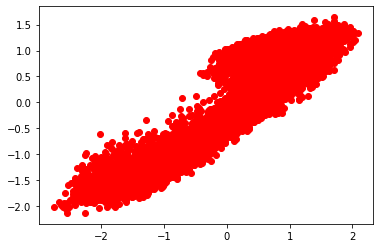

In [13]:
plt.scatter(df['Tmax'],df['Tmin'],color='red')

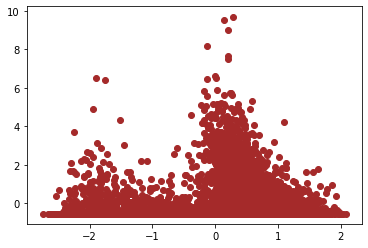

In [14]:
plt.scatter(df['Tmax'],df['rainfall'],color='brown')

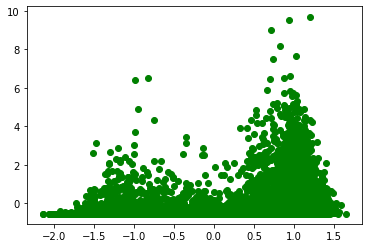

In [15]:
plt.scatter(df['Tmin'],df['rainfall'],color='green')

# class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')

In [16]:
######################### KMeans Clustering #######################
kmeans=KMeans(n_clusters=5)
model=kmeans.fit(df1)                      # Fitting the model
print(model)

predict=np.reshape([1.9,-1.3,4.5],(1,-1)) # predicting using the model
model.predict(predict)

KMeans(n_clusters=5)


array([4], dtype=int32)

In [17]:
centers=model.cluster_centers_
c_data={'Tmax':centers[:,0], 'Tmin':centers[:,1], 'rainfall': centers[:,2],'labels':np.arange(1,6,1)}
Centers=pd.DataFrame(data=c_data)

labels=kmeans.labels_
Labels=pd.Series(labels)
df1['Labels']=Labels
df1.shape

df2=df1.dropna(axis=0)
df2
#Centers

/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Tmax,Tmin,rainfall,Labels
0,-1.704710,-1.579997,-0.546132,2.0
1,-1.755340,-1.574935,-0.549006,2.0
2,-1.853316,-1.600216,-0.549006,2.0
3,-1.886320,-1.566953,-0.549006,2.0
4,-1.924903,-1.642098,-0.549006,2.0
...,...,...,...,...
7299,-1.378513,-1.359186,-0.549006,2.0
7300,-1.901708,-1.094672,-0.503859,2.0
7301,-2.249736,-0.981242,3.724582,2.0
7302,-2.043100,-1.292304,2.660854,2.0


# Attributes associated with KMeans object

In [18]:
model.cluster_centers_

array([[-0.12634064, -0.44842042, -0.47186603],
       [ 0.94779182,  0.79923996, -0.31931998],
       [-1.42122143, -1.364431  , -0.40737831],
       [ 0.44180762,  0.96956741,  1.16142367],
       [ 0.13455141,  0.83439854,  3.50590528]])

In [19]:
model.labels_                 # Labels of each point

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [20]:
model.inertia_                 # Sum of squared distances of samples to their closest cluster center

3146.4141212297573

In [21]:
model.n_iter_                 # No of iterations run

7

In [22]:
model.n_features_in_         # Number of features seen during fit

3

# Plotting the sample points along with centroids

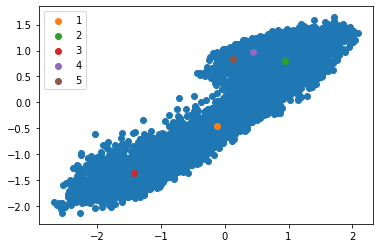

In [23]:
plt.scatter(df2['Tmax'],df2['Tmin'])
plt.scatter(centers[0,0],centers[0,1],label='1')
plt.scatter(centers[1,0],centers[1,1],label='2')
plt.scatter(centers[2,0],centers[2,1],label='3')
plt.scatter(centers[3,0],centers[3,1],label='4')
plt.scatter(centers[4,0],centers[4,1],label='5')
plt.legend()

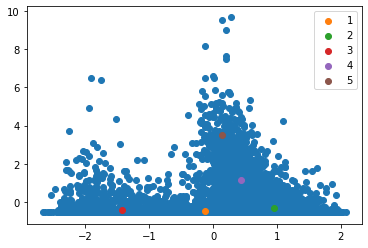

In [24]:
plt.scatter(df2['Tmax'],df2['rainfall'])
plt.scatter(centers[0,0],centers[0,2],label='1')
plt.scatter(centers[1,0],centers[1,2],label='2')
plt.scatter(centers[2,0],centers[2,2],label='3')
plt.scatter(centers[3,0],centers[3,2],label='4')
plt.scatter(centers[4,0],centers[4,2],label='5')
plt.legend()

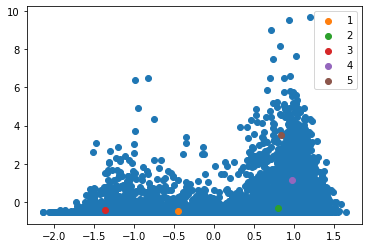

In [25]:
plt.scatter(df2['Tmin'],df2['rainfall'])
plt.scatter(centers[0,1],centers[0,2],label='1')
plt.scatter(centers[1,1],centers[1,2],label='2')
plt.scatter(centers[2,1],centers[2,2],label='3')
plt.scatter(centers[3,1],centers[3,2],label='4')
plt.scatter(centers[4,1],centers[4,2],label='5')
plt.legend()

# Some Parallel Plot Analysis

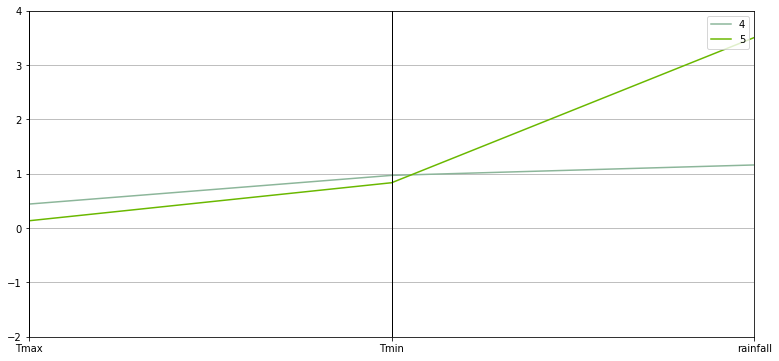

In [26]:
plt.figure(figsize=(13,6)).gca().axes.set_ylim([-2,+4])
pd.plotting.parallel_coordinates(Centers[Centers['rainfall']>0],'labels')

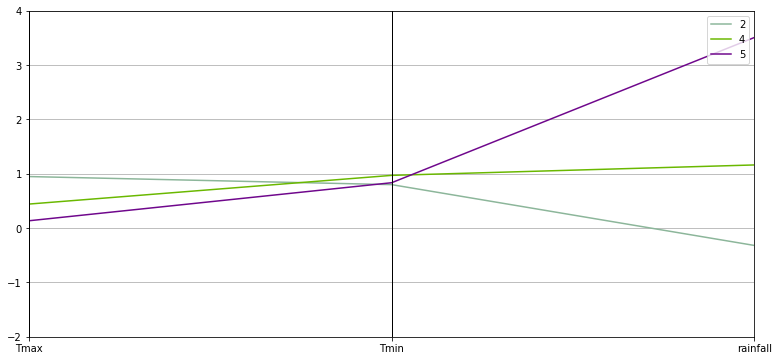

In [27]:
plt.figure(figsize=(13,6)).gca().axes.set_ylim([-2,+4])
pd.plotting.parallel_coordinates(Centers[Centers['Tmax']>0],'labels')

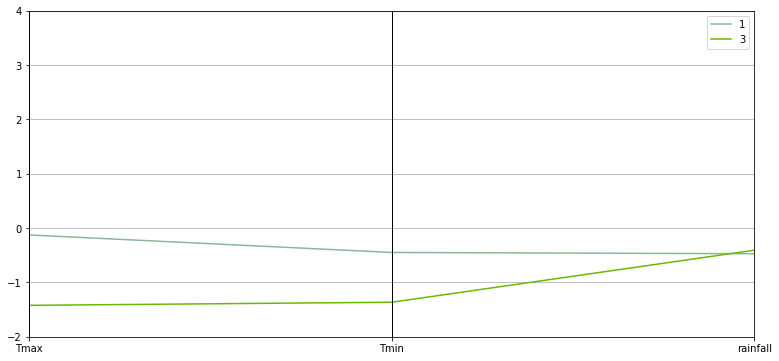

In [28]:
plt.figure(figsize=(13,6)).gca().axes.set_ylim([-2,+4])
pd.plotting.parallel_coordinates(Centers[Centers['Tmin']<0],'labels')

# Scatter plot of all sample points with different colors to each cluster

In [29]:
cluster1=df2.loc[df2['Labels']==0]
cluster2=df2.loc[df2['Labels']==1]
cluster3=df2.loc[df2['Labels']==2]
cluster4=df2.loc[df2['Labels']==3]
cluster5=df2.loc[df2['Labels']==4]
cluster4

,Tmax,Tmin,rainfall,Labels
126,0.966452,0.656928,0.700400,3.0
151,0.970217,0.863971,0.848187,3.0
155,1.186448,1.055164,0.644529,3.0
166,0.990151,1.269912,0.592215,3.0
167,0.915643,1.153789,0.747500,3.0
...,...,...,...,...
7204,0.533059,1.134014,0.587365,3.0
7207,0.835724,1.120129,-0.392359,3.0
7211,0.404160,1.001399,0.546572,3.0
7213,0.579292,0.956641,0.187812,3.0


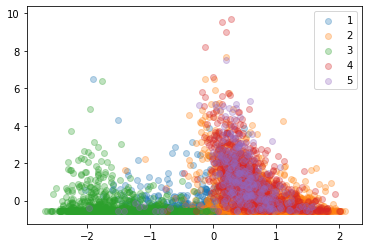

In [30]:
plt.scatter(cluster1['Tmax'],cluster1['rainfall'],alpha=0.3,label='1')
plt.scatter(cluster2['Tmax'],cluster2['rainfall'],alpha=0.3,label='2')
plt.scatter(cluster3['Tmax'],cluster3['rainfall'],alpha=0.3,label='3')
plt.scatter(cluster4['Tmax'],cluster4['rainfall'],alpha=0.3,label='4')
plt.scatter(cluster5['Tmax'],cluster5['rainfall'],alpha=0.3,label='5')
plt.legend()

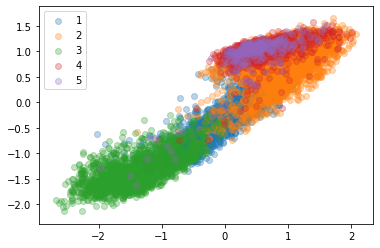

In [31]:
plt.scatter(cluster1['Tmax'],cluster1['Tmin'],alpha=0.3,label='1')
plt.scatter(cluster2['Tmax'],cluster2['Tmin'],alpha=0.3,label='2')
plt.scatter(cluster3['Tmax'],cluster3['Tmin'],alpha=0.3,label='3')
plt.scatter(cluster4['Tmax'],cluster4['Tmin'],alpha=0.3,label='4')
plt.scatter(cluster5['Tmax'],cluster5['Tmin'],alpha=0.3,label='5')
plt.legend()

# To Make an Interactive 3d plot of the clusters

In [32]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Labels']==n]['rainfall'],
        y = db[db['Labels']==n]['Tmax'],
        z = db[db['Labels']==n]['Tmin'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(df2, 0, 'Cluster 0')
trace1 = tracer(df2, 1, 'Cluster 1')
trace2 = tracer(df2, 2, 'Cluster 2')
trace3 = tracer(df2, 3, 'Cluster 3')
trace4 = tracer(df2, 4, 'Cluster 4')

plot_data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Rainfall'),
            yaxis = dict(title = 'Tmax'),
            zaxis = dict(title = 'Tmin')
        )
)

fig = go.Figure(data=plot_data, layout=layout)
py.offline.iplot(fig)


ModuleNotFoundError: No module named 'plotly'